In [1]:
import numpy
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


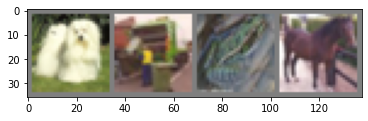

  dog truck  frog horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [10]:
print(len(trainset))
print(len(testset))

50000
10000


In [11]:
x,y = trainset[0]
print(x.shape)

torch.Size([3, 32, 32])


In [36]:
class network_in_network(nn.Module):
    def __init__(self):
        super(network_in_network, self).__init__()
        self.classifier = nn.Sequential(
                nn.BatchNorm2d(3),
                nn.Conv2d(3, 192, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(192),
                nn.ELU(inplace=True),
                nn.Conv2d(192, 160, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(160),
                nn.ELU(inplace=True),
                nn.Conv2d(160,  96, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(96),
                nn.ELU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                nn.Dropout(0.5),

                nn.Conv2d(96, 192, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(192),
                nn.ELU(inplace=True),
                nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(192),
                nn.ELU(inplace=True),
                nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(192),
                nn.ELU(inplace=True),
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Dropout(0.5),

                nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(192),
                nn.ELU(inplace=True),
                nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(192),
                nn.ELU(inplace=True),
                nn.Conv2d(192,  10, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(10),
                nn.ELU(inplace=True),
                nn.AvgPool2d(kernel_size=8, stride=1, padding=0),

                )

    def forward(self, x):
        x = self.classifier(x)
        x = x.view(x.size(0), 10)
        x = F.log_softmax(x, dim=1)
        return x

In [37]:
device = torch.device('cuda:0')
model = network_in_network().to(device)
next(model.parameters()).is_cuda

True

In [38]:
x = torch.rand(4,3,32,32).to(device)
y = model(x)
print(y.shape)

torch.Size([4, 10])


In [39]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

969828

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

epochs = 5

train_loss = 0

train_losses = []
test_losses = []
model.train()

print("Start training...")
for e in range(epochs):

    steps = 0
    for img, class_ in trainloader:
        steps +=1

        img = img.to(device).float()
        class_ = class_.to(device)

        try:
          outputs = model(img)
        except:
          continue

        loss = criterion(outputs, class_)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    test_loss=0
    accuracy = 0
    with torch.no_grad():
        model.eval()
        for img, class_ in testloader:

                img = img.to(device).float()
                class_ = class_.to(device)

                predictions = model(img)
                loss = criterion(predictions, class_)
                test_loss += loss.item()
                ps = torch.exp(predictions)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == class_.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

    running_train_loss = train_loss/len(trainloader)
    running_valid_loss = test_loss/len(testloader)

    print("Epoch: {}/{}.. ".format(e+1, epochs),
        "Training Loss: {:.3f}.. ".format(running_train_loss),
        "Validation Loss: {:.3f} ".format(running_valid_loss),
        "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

    train_losses.append(running_train_loss)
    test_losses.append(running_valid_loss)

    validation_batches = []
    train_loss = 0

    model.train()



Start training...
Epoch: 1/5..  Training Loss: 1.608..  Validation Loss: 1.141  Test Accuracy: 0.624
Epoch: 2/5..  Training Loss: 1.482..  Validation Loss: 1.041  Test Accuracy: 0.660
Epoch: 3/5..  Training Loss: 1.377..  Validation Loss: 0.922  Test Accuracy: 0.693
Epoch: 4/5..  Training Loss: 1.288..  Validation Loss: 0.869  Test Accuracy: 0.714
Epoch: 5/5..  Training Loss: 1.206..  Validation Loss: 0.802  Test Accuracy: 0.740


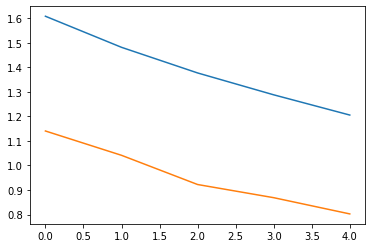

In [43]:
plt.figure()
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()